In [7]:
#!pip install tensorflow==1.14.0

In [8]:
#!pip install keras==2.2.5

In [9]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [10]:
import gc
import warnings

import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [11]:
site_id = 5

In [12]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

df_train = df_train[~((df_train.building_id == 656) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 657) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 658) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 659) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 660) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 661) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 662) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 663) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 664) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 666) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 667) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 668) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 669) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 669) & (df_train.log_meter_reading > 3))]
df_train = df_train[~((df_train.building_id == 670) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 671) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 672) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 674) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 675) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 675) & (df_train.timestamp >= "2016-02") & (df_train.timestamp < "2016-06"))]
df_train = df_train[~((df_train.building_id == 677) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 678) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 680) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 681) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 683) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 684) & (df_train.log_meter_reading < 1.5))]
df_train = df_train[~((df_train.building_id == 685) & (df_train.log_meter_reading < 2))]
df_train = df_train[~((df_train.building_id == 687) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 688) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 689) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 690) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 692) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 693) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 694) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 697) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 698) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 701) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 702) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 703) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 704) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 705) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 707) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 708) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 709) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 710) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 711) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 712) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 713) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 714) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 715) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 716) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 717) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 718) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 719) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 720) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 721) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 722) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 723) & (df_train.log_meter_reading < 2))]
df_train = df_train[~((df_train.building_id == 724) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 725) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 727) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 728) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 729) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 730) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 731) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 732) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 733) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 734) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 735) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 736) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 739) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 741) & (df_train.log_meter_reading < 0.5))]
df_train = df_train[~((df_train.building_id == 742) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 743) & (df_train.log_meter_reading < 1))]
df_train = df_train[~((df_train.building_id == 744) & (df_train.log_meter_reading < 1))]
df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

del building
gc.collect()

0

In [13]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [14]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [15]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [16]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 5 and meter 0
Preparing Site: 5 , meter: 0 , Fold: 1




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 569823 samples, validate on 189942 samples
Epoch 1/31
 - 9s - loss: 1.9186 - val_loss: 1.0895
Epoch 2/31
 - 8s - loss: 1.2066 - val_loss: 1.0652
Epoch 3/31
 - 8s - loss: 1.1683 - val_loss: 1.0715
Epoch 4/31
 - 8s - loss: 1.1517 - val_loss: 1.0930
Epoch 5/31
 - 8s - loss: 1.1379 - val_loss: 1.1151
Epoch 6/31
 - 8s - loss: 1.1257 - val_loss: 1.1285
Epoch 7/31
 - 8s - loss: 1.1143 - val_loss: 1.1271
Epoch 8/31
 - 8s - loss: 1.1053 - val_loss: 1.1153
Epoch 9/31
 - 8s - loss: 1.0963 - val_loss: 1.1225
Epoch 10/31
 - 8s - loss: 1.0881 - val_loss: 1.1261
Epoch 11/31
 - 8s - loss: 1.0811 - val_loss: 1.1229
Epoch 12/31
 - 8s - loss: 1.0739 - val_loss: 1.1433
Epoch 13/31
 - 8s - loss: 1.0687 - val

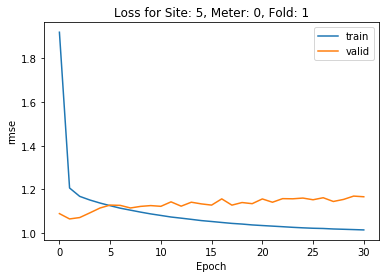

Preparing Site: 5 , meter: 0 , Fold: 2
Train on 569824 samples, validate on 189941 samples
Epoch 1/31
 - 9s - loss: 1.8915 - val_loss: 1.1117
Epoch 2/31
 - 7s - loss: 1.2160 - val_loss: 1.0457
Epoch 3/31
 - 8s - loss: 1.1695 - val_loss: 1.0189
Epoch 4/31
 - 8s - loss: 1.1480 - val_loss: 1.0032
Epoch 5/31
 - 8s - loss: 1.1300 - val_loss: 1.0012
Epoch 6/31
 - 8s - loss: 1.1140 - val_loss: 0.9664
Epoch 7/31
 - 8s - loss: 1.1017 - val_loss: 0.9487
Epoch 8/31
 - 8s - loss: 1.0898 - val_loss: 0.9479
Epoch 9/31
 - 8s - loss: 1.0806 - val_loss: 0.9573
Epoch 10/31
 - 8s - loss: 1.0721 - val_loss: 0.9428
Epoch 11/31
 - 7s - loss: 1.0641 - val_loss: 0.9477
Epoch 12/31
 - 7s - loss: 1.0570 - val_loss: 0.9461
Epoch 13/31
 - 8s - loss: 1.0500 - val_loss: 0.9503
Epoch 14/31
 - 8s - loss: 1.0440 - val_loss: 0.9565
Epoch 15/31
 - 8s - loss: 1.0386 - val_loss: 0.9528
Epoch 16/31
 - 8s - loss: 1.0336 - val_loss: 0.9575
Epoch 17/31
 - 8s - loss: 1.0293 - val_loss: 0.9519
Epoch 18/31
 - 7s - loss: 1.0252 -

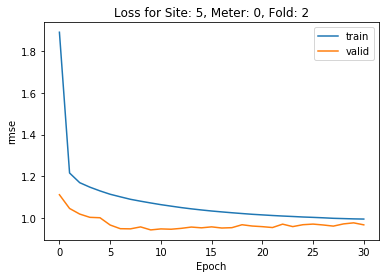

Preparing Site: 5 , meter: 0 , Fold: 3
Train on 569824 samples, validate on 189941 samples
Epoch 1/31
 - 10s - loss: 2.0447 - val_loss: 0.7151
Epoch 2/31
 - 8s - loss: 1.3477 - val_loss: 0.6812
Epoch 3/31
 - 8s - loss: 1.2949 - val_loss: 0.6716
Epoch 4/31
 - 8s - loss: 1.2785 - val_loss: 0.6527
Epoch 5/31
 - 8s - loss: 1.2641 - val_loss: 0.6406
Epoch 6/31
 - 8s - loss: 1.2472 - val_loss: 0.6277
Epoch 7/31
 - 8s - loss: 1.2340 - val_loss: 0.6106
Epoch 8/31
 - 8s - loss: 1.2234 - val_loss: 0.6122
Epoch 9/31
 - 8s - loss: 1.2143 - val_loss: 0.6028
Epoch 10/31
 - 8s - loss: 1.2061 - val_loss: 0.5912
Epoch 11/31
 - 8s - loss: 1.1989 - val_loss: 0.5893
Epoch 12/31
 - 8s - loss: 1.1924 - val_loss: 0.5855
Epoch 13/31
 - 8s - loss: 1.1859 - val_loss: 0.5890
Epoch 14/31
 - 8s - loss: 1.1809 - val_loss: 0.5811
Epoch 15/31
 - 8s - loss: 1.1755 - val_loss: 0.5816
Epoch 16/31
 - 8s - loss: 1.1701 - val_loss: 0.5873
Epoch 17/31
 - 8s - loss: 1.1658 - val_loss: 0.5873
Epoch 18/31
 - 8s - loss: 1.1620 

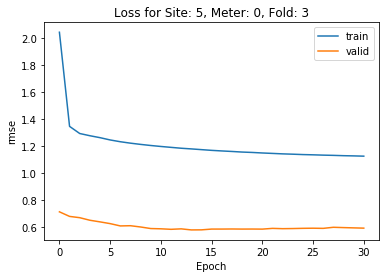

Preparing Site: 5 , meter: 0 , Fold: 4
Train on 569824 samples, validate on 189941 samples
Epoch 1/31
 - 10s - loss: 1.8459 - val_loss: 1.3894
Epoch 2/31
 - 8s - loss: 1.1605 - val_loss: 1.2819
Epoch 3/31
 - 8s - loss: 1.1138 - val_loss: 1.2614
Epoch 4/31
 - 8s - loss: 1.0954 - val_loss: 1.2350
Epoch 5/31
 - 8s - loss: 1.0783 - val_loss: 1.2033
Epoch 6/31
 - 8s - loss: 1.0628 - val_loss: 1.1618
Epoch 7/31
 - 8s - loss: 1.0481 - val_loss: 1.1548
Epoch 8/31
 - 8s - loss: 1.0372 - val_loss: 1.1257
Epoch 9/31
 - 8s - loss: 1.0270 - val_loss: 1.1294
Epoch 10/31
 - 8s - loss: 1.0182 - val_loss: 1.1113
Epoch 11/31
 - 8s - loss: 1.0111 - val_loss: 1.1105
Epoch 12/31
 - 8s - loss: 1.0038 - val_loss: 1.1021
Epoch 13/31
 - 8s - loss: 0.9985 - val_loss: 1.1062
Epoch 14/31
 - 8s - loss: 0.9933 - val_loss: 1.1101
Epoch 15/31
 - 8s - loss: 0.9873 - val_loss: 1.1039
Epoch 16/31
 - 8s - loss: 0.9822 - val_loss: 1.0993
Epoch 17/31
 - 8s - loss: 0.9783 - val_loss: 1.0961
Epoch 18/31
 - 8s - loss: 0.9742 

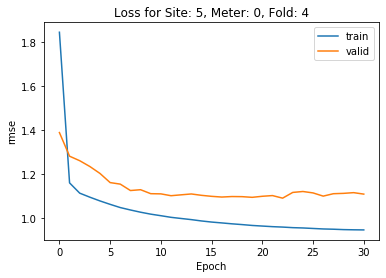


CV RMSE for Site: 5 and Meter: 0 is 1.0923165744616756

CV RMSE for Site: 5 is 1.0923165744616756


In [17]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(128, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(32, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=31, batch_size=1000, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [20]:
#df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)